In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'boy is strong', 
          'girl is pretty',
          'girl is wise',
          'prince is a boy will be king',
          'princess is a girl will be queen']

stopwords=['is', 'a', 'will', 'be']

In [4]:
def remove_stopwords(corpus, stopwords):
    new_corpus=[]

    for sent in corpus:
        sent=sent.split()

        new_sent=[]
        for word in sent:
            if word in stopwords:
                pass
            else:
                new_sent.append(word)

        sent=' '.join(new_sent)
        new_corpus.append(sent)     
        
    return new_corpus

corpus=remove_stopwords(corpus, stopwords)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'boy strong',
 'girl pretty',
 'girl wise',
 'prince boy king',
 'princess girl queen']

In [5]:
words=list(map(lambda x: x.split(), corpus))

vocab=set(itertools.chain(*words))
word2int=dict(zip(vocab,range(len(vocab))))
word2int

{'wise': 0,
 'young': 1,
 'king': 2,
 'strong': 3,
 'queen': 4,
 'prince': 5,
 'man': 6,
 'woman': 7,
 'girl': 8,
 'boy': 9,
 'princess': 10,
 'pretty': 11}

In [6]:
WINDOW_SIZE=2
input_data=[]

for sent in corpus:
    words=sent.split()
    
    for idx, target  in enumerate(words):

        context=words[max(0,idx-WINDOW_SIZE):min(len(words),idx+WINDOW_SIZE)+1]
        context.remove(target)

        for w in context:
            input_data.append([target,w])

In [7]:
df=pd.DataFrame(input_data,columns=['input','label'])
df.shape

(58, 2)

In [8]:
df.head()

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king


In [9]:
df=df.replace(word2int)
df.head()

,input,label
0,2,3
1,2,6
2,3,2
3,3,6
4,6,2


In [10]:
I=np.eye(len(vocab))

data = np.array(list(map(lambda x: I[x], df['input'].values)))
target = df['label'].values

train, val = train_test_split(list(zip(data, target)), test_size=0.1, random_state=SEED)

len(train), len(val)

(52, 6)

In [11]:
BATCH_SIZE = 2

train_iterator = torch.utils.data.DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
val_iterator = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

len(train_iterator), len(val_iterator) 

(26, 3)

In [12]:
input_dim = len(vocab)
hidden_dim = 2
output_dim = len(vocab)
dropout_rate = 0

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super().__init__()
            
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.do1 = nn.Dropout(p=dropout_rate)
        self.do2 = nn.Dropout(p=dropout_rate)
        
    def forward(self, x):
        hidden = self.do1(self.fc1(x))
        output = torch.softmax(self.do2(self.fc2(hidden)), axis=1)
        
        return output
    
model = MLP(input_dim, hidden_dim, output_dim, dropout_rate)

In [13]:
model

MLP(
  (fc1): Linear(in_features=12, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=12, bias=True)
  (do1): Dropout(p=0, inplace=False)
  (do2): Dropout(p=0, inplace=False)
)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

62

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=10)

criterion = nn.CrossEntropyLoss()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
model = model.to(device)
criterion = criterion.to(device)

In [18]:
def calculate_accuracy(y_score, y):
    
    y_pred = torch.argmax(y_score, axis=1)
    
    return sum(y_pred == y) / len(y)

In [19]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for x, y in iterator:
        
        optimizer.zero_grad()
        
        x=x.float().to(device)
        y=y.to(device)
        
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        y_score = model(x)
        
        loss = criterion(y_score, y)
        acc = calculate_accuracy(y_score, y)        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc / len(iterator)

In [20]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    for x, y in iterator:
        
        x=x.float().to(device)
        y=y.to(device)
        
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        y_score = model(x)
        
        loss = criterion(y_score, y)
        acc = calculate_accuracy(y_score, y)
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc / len(iterator)

In [21]:
EPOCHS = 200

TRAIN_LOSS=[]
VAL_LOSS=[]

TRAIN_ACC=[]
VAL_ACC=[]

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    val_loss, val_acc = evaluate(model, val_iterator, criterion, device)
    
    scheduler.step(val_loss)
    
    TRAIN_LOSS.append(train_loss)
    VAL_LOSS.append(val_loss)
    
    TRAIN_ACC.append(train_acc)
    VAL_ACC.append(val_acc)
    
print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}')
print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.02it/s]

Train Loss: 2.460 | Train Acc: 0.154
Val Loss: 2.475 | Val Acc: 0.333


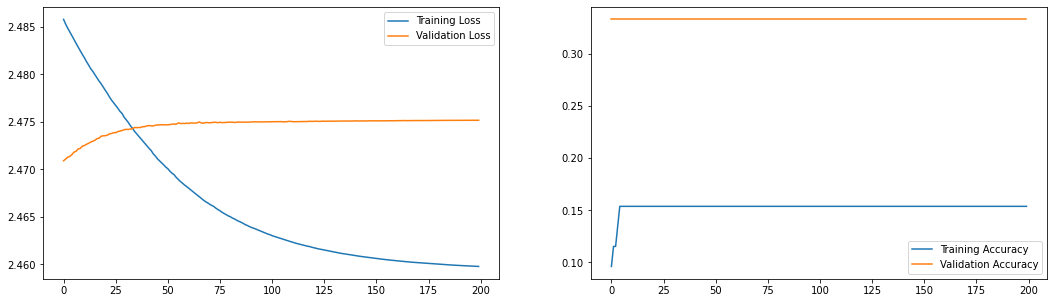

In [22]:
fig=plt.figure(figsize=(18,5))

plt.subplot(121)

plt.plot(TRAIN_LOSS, label='Training Loss')
plt.plot(VAL_LOSS, label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(TRAIN_ACC, label='Training Accuracy')
plt.plot(VAL_ACC, label='Validation Accuracy')
plt.legend()

plt.show()

We notice that our validation loss is increasing with time. 

This is a common case of **overfitting** and this is primiarily because of **small size of dataset**.

In [23]:
embedding_data = model.fc1(torch.Tensor(I)).detach().numpy()
df_word2vec = pd.DataFrame(embedding_data, columns=['X1','X2'])

df_word2vec['word'] = word2int.keys()

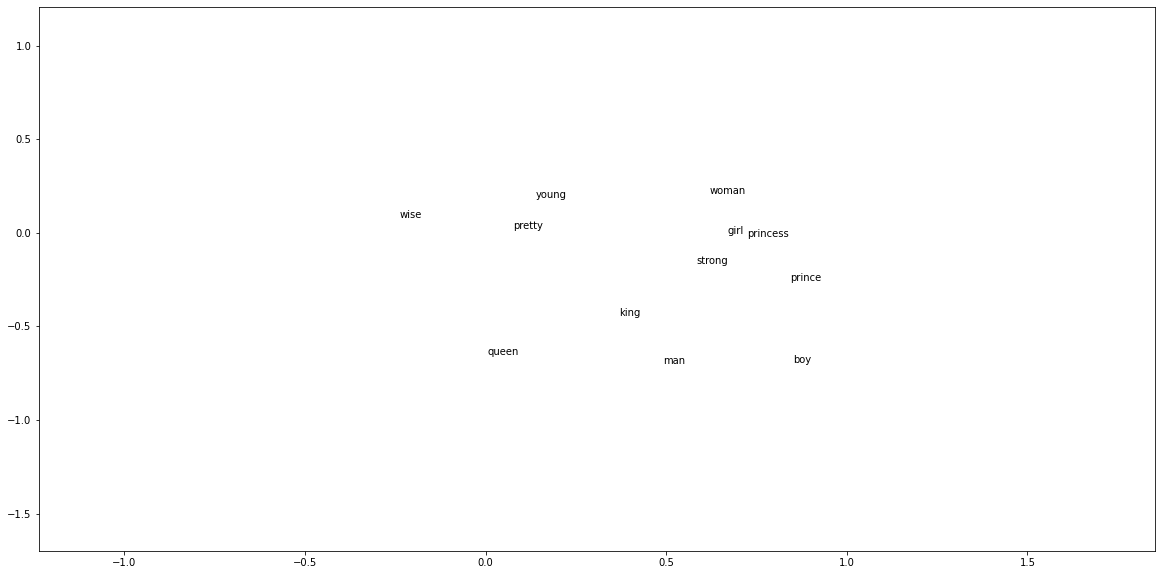

In [24]:
fig, ax = plt.subplots(figsize=(20,10))

for word, x1, x2 in zip(df_word2vec['word'], df_word2vec['X1'], df_word2vec['X2']):
    ax.annotate(word, (x1, x2))
    
PADDING = 1.0
x_axis_min = np.amin(embedding_data, axis=0)[0] - PADDING
y_axis_min = np.amin(embedding_data, axis=0)[1] - PADDING
x_axis_max = np.amax(embedding_data, axis=0)[0] + PADDING
y_axis_max = np.amax(embedding_data, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()